# Recreate the GAMA cross correlation using `meer21cm`

This notebook aims at recreating the `meerpower` pipeline for the results used in cross-correlation between L-band deep-field data and GAMA galaxy. Through building this, people who used `meerpower` should be able to migrate to `meer21cm` relatively easily. 

This notebook is largely unfinished and in early stages. Due to adhering to PEP8 and other design philosophy reasons, many functionalities are not going to be identical copies. The goal right now is to recreate every figure in almost identical manner. But hopefully this is still straightforward enough to adapt to.

In [1]:
from astropy.cosmology import Planck18
import matplotlib.pyplot as plt
import numpy as np
from meer21cm.cosmology import CosmologyCalculator
from meer21cm.io import filter_incomplete_los, read_map, cal_freq
from astropy.wcs import WCS
from meer21cm.plot import *
from meer21cm.telescope import dish_beam_sigma, gaussian_beam, isotropic_beam_profile, weighted_convolution
from meer21cm.util import pcaclean, freq_to_redshift, redshift_to_freq
from hiimtool.basic_util import centre_to_edges
from astropy.io import fits
from astropy.wcs.utils import proj_plane_pixel_area
from meer21cm.grid import *
from scipy import signal

[Zhaotinndiannao:08111] shmem: mmap: an error occurred while determining whether or not /var/folders/g4/7xh65ljx6l17g9wztg7t6c2w0000gn/T//ompi.Zhaotinndiannao.501/jf.0/435617792/sm_segment.Zhaotinndiannao.501.19f70000.0 could be created.


The readin function has been rewritten. Counts file need to be passed explicitly. The goal is to avoid writing things to specific datasets that will be invalid later.

`nu` is in Hz now and the map is either in Kelvin of Jansky. It is better that we stick to consistent units throughout and use SI units whenever reasonable and then common units (Mpc, Jy etc) if needed. If one functionality uses non-standard unit, the unit of the input should be an explicit argument.

The `read_map` function does not return `w_HI`. It was simply set to uniform in the original function which is confusing.

In [2]:
cosmo = Planck18
file_dir = '/Users/zhaotingchen/Desktop/work/sd_stacking/draft/'
fits_file = file_dir+'Nscan961_Tsky_cube_p0.3d_sigma4.0_iter2.fits'
counts_file = file_dir+'Nscan961_Npix_count_cube_p0.3d_sigma4.0_iter2.fits'
numin=971*1e6
numax=1023.8*1e6
MKmap,counts_HI,W_HI,ra,dec,nu,wproj = read_map(
    fits_file,
    counts_file,
    nu_min = numin,
    nu_max = numax,
)
w_HI = counts_HI.copy()
nx,ny,nz = np.shape(MKmap)
MKmap,W_HI,w_HI,counts_HI = filter_incomplete_los(MKmap,W_HI,w_HI,counts_HI)
z_ch = freq_to_redshift(nu)

The plot utility is largely kept the same

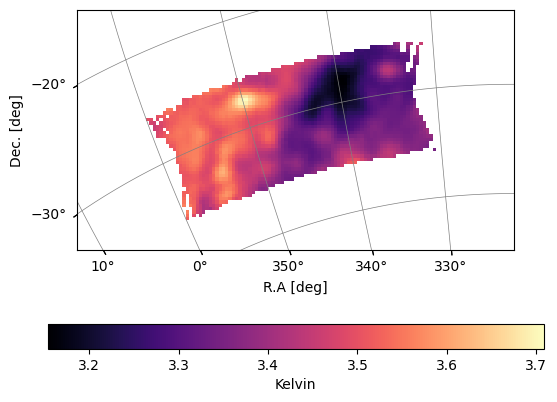

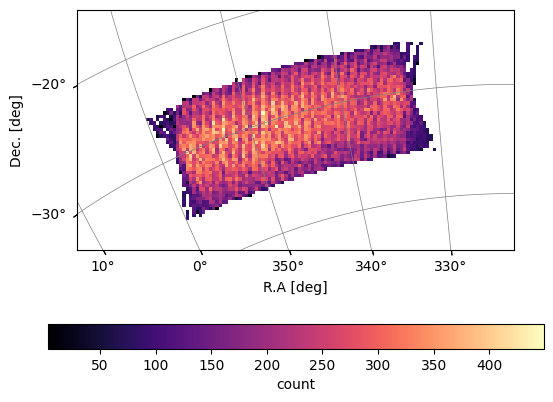

In [3]:
plot_map(MKmap,wproj,W=W_HI,cbar_label='Kelvin')
plot_map(w_HI,wproj,W=W_HI,cbar_label='count')

The reconvolution function is decomposed and rewritten. Now, there are a few modulised steps to do this. This is so that when we want to change the beam function (e.g. sinc instead of gaussian) or do other things, the code should be able to handle that.

First, we retrieve the Gaussian beam size just like before, now using `dish_beam_sigma`.

In [4]:
D_dish = 13.5 # Dish-diameter [metres]
gamma = 1.4 # resmoothing factor - set = None to have no resmoothing
sigma_ch = dish_beam_sigma(D_dish,nu,)
sigma_max = sigma_ch.max()

Deconvolution and then reconvolution in Fourier space is just divide the beam kernel and then multiply the new beam kernel. Therefore in real space the denominator of the exponential subtracts each other: 

In [5]:
reconvolve_sigma = np.sqrt(gamma*sigma_max**2 - sigma_ch**2)

Then, an image of the beam on the fits grids is made. Note that a different function and a sigma would also work as long as the beam does not have directionality using `isotropic_beam_profile`

In [6]:
beam_cube = np.zeros_like(MKmap)
for i in range(len(nu)):
    beam_func = gaussian_beam(reconvolve_sigma[i])
    beam_cube[:,:,i] = isotropic_beam_profile(nx,ny,wproj,beam_func)

Finally, a weighted convolution can be performed with the beam cube

In [7]:
MKmap,w_HI = weighted_convolution(MKmap,beam_cube,w_HI)
# remove artefacts outside the range
MKmap *= W_HI
w_HI *= W_HI

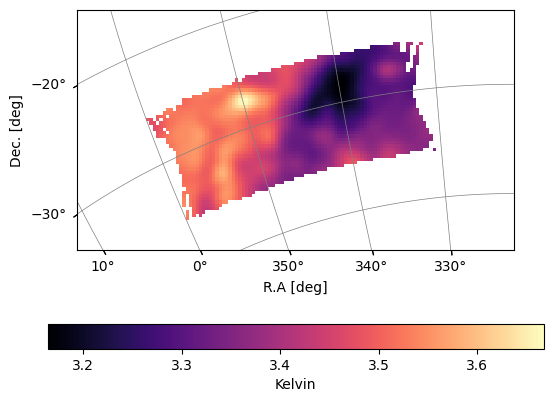

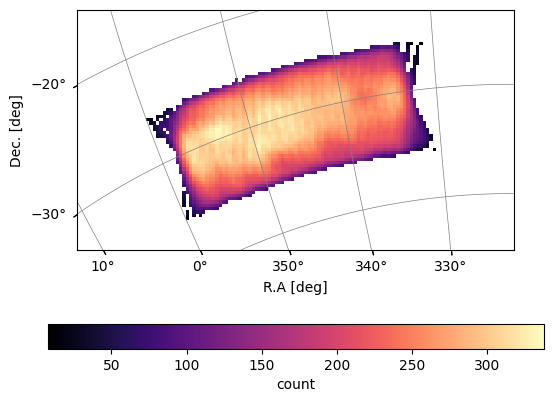

In [8]:
plot_map(MKmap,wproj,W=W_HI,cbar_label='Kelvin')
plot_map(w_HI,wproj,W=W_HI,cbar_label='count')

Examining the los spectrum is now `plot_pixels_along_los`

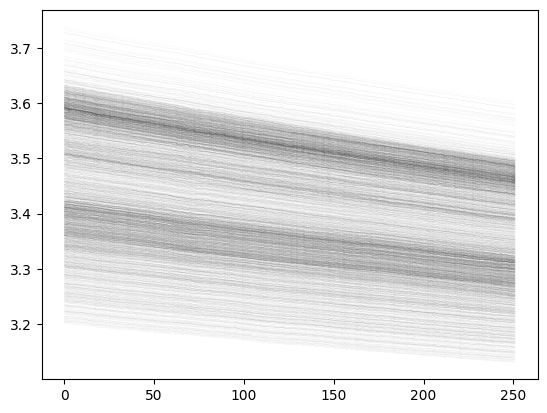

In [9]:
plot_pixels_along_los(MKmap,W_HI)

PCA cleaning is rewritten to tidy up the code but also to address several inconsistencies:

- The calculation of covariance is not renormalised if we simply do `np.cov(weight*map)`.
- Calculation of the mean of the data vector should be consistent with the covariance. That is, if weights are used in covariance, it should also be used in calculating the mean
- Only one weight should be used at a time. So if a binary mask is used, then the counts are not used, vice versa.

In my test, actually non-weighted PCA works better it seems:

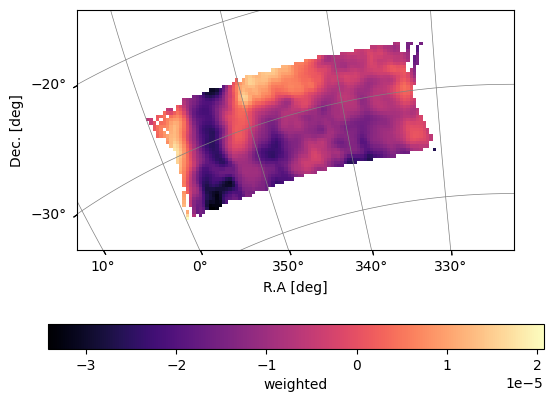

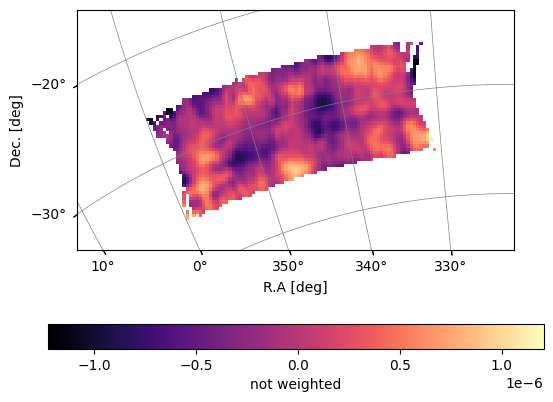

In [10]:
N_fg = 10
MKmap_clean = pcaclean(MKmap,N_fg,weights=w_HI,mean_centre=True)
plot_map(MKmap_clean,wproj,W=W_HI,cbar_label='weighted')

N_fg = 10
MKmap_clean = pcaclean(MKmap,N_fg,weights=W_HI,mean_centre=True)
plot_map(MKmap_clean,wproj,W=W_HI,cbar_label='not weighted')

In [11]:
cov_map,eignumb,eigenval,V = pcaclean(MKmap,N_fg=1,weights=W_HI,return_analysis=True,mean_centre=True) # weights included in covariance calculation


In [12]:
nu_edges = centre_to_edges(nu)

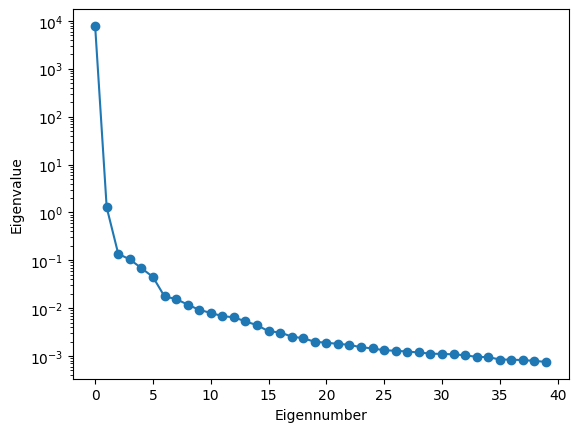

<Figure size 640x480 with 0 Axes>

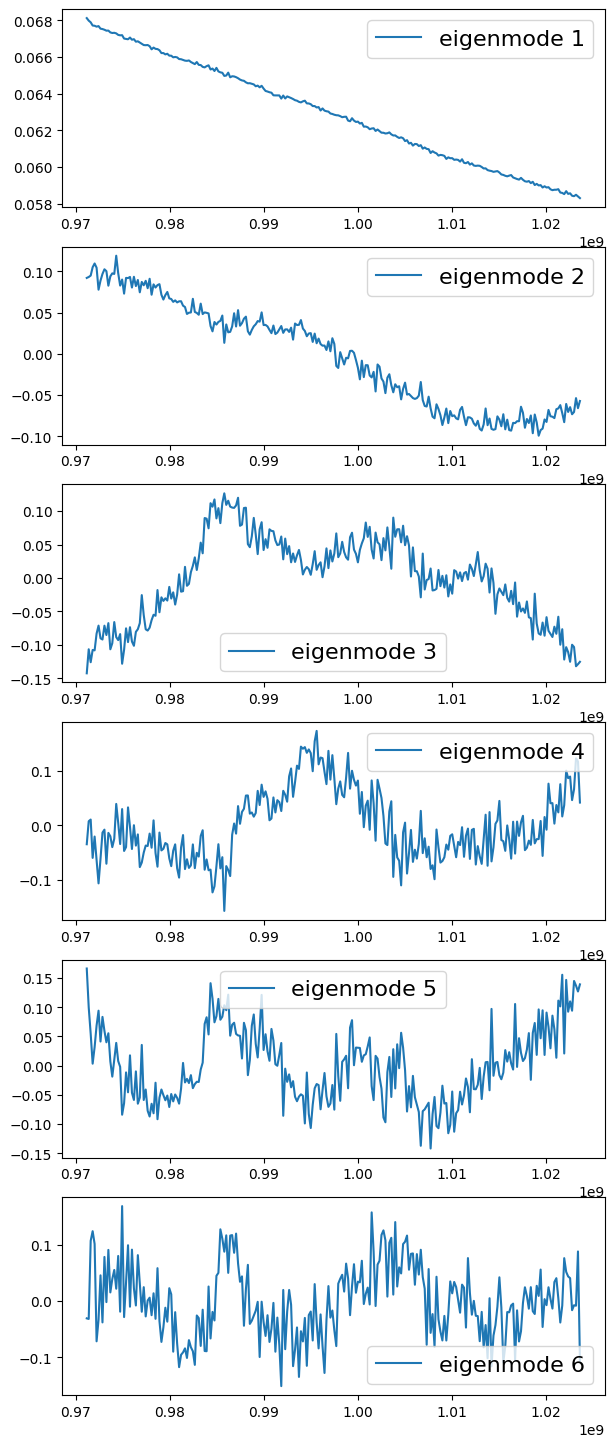

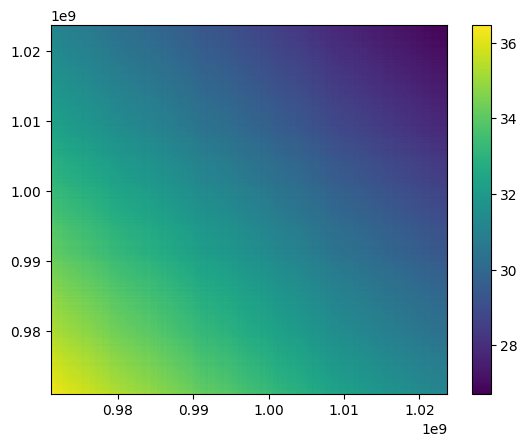

In [13]:
plot_eigenspectrum(np.array([eigenval]))
plt.figure()
Num = 6
chart = 100*Num + 11
plt.figure(figsize=(7,3*Num))
for i in range(Num):
    plt.subplot(chart + i)
    plt.plot(nu,V[:,i],label='eigenmode %s'%(i+1))
    #plt.plot(nu,V[:,i],label='eigenmode %s'%(i+1))
    plt.legend(fontsize=16)
plt.figure()
plt.pcolormesh(nu_edges,nu_edges,cov_map)
plt.colorbar()
plt.show()

Read in the GAMA galaxy positions:

In [14]:
gal_file = file_dir+'../G23TilingCatv11.fits'
hdu = fits.open(gal_file)
hdr = hdu[1].header
#print(hdr)
ra_g = hdu[1].data['RA'] # Right ascension (J2000) [deg]
dec_g = hdu[1].data['DEC'] # Declination (J2000) [deg]
z_g = hdu[1].data['Z'] # Spectroscopic redshift, -1 for none attempted

### Cut redshift to MeerKAT IM range:
zmin, zmax = z_ch.min(),z_ch.max()
z_Lband = (z_g>zmin) & (z_g<zmax)
ra_g = ra_g[z_Lband]
dec_g = dec_g[z_Lband]
z_g = z_g[z_Lband]

### Remove galaxies outside bulk GAMA footprint so they don't bias the simple binary selection function
raminGAMA,ramaxGAMA = 339,351
decminGAMA,decmaxGAMA = -35,-30
GAMAcutmask = (ra_g>raminGAMA) & (ra_g<ramaxGAMA) & (dec_g>decminGAMA) & (dec_g<decmaxGAMA)
ra_g,dec_g,z_g = ra_g[GAMAcutmask],dec_g[GAMAcutmask],z_g[GAMAcutmask]


Trim sub-map for cross-power:

In [15]:
GAMAmapmask = (ra>raminGAMA) & (ra<ramaxGAMA) & (dec>decminGAMA) & (dec<decmaxGAMA)
W_HI_gama = W_HI.copy()*GAMAmapmask[:,:,None]
MKmap_gama = MKmap_clean.copy()*GAMAmapmask[:,:,None]

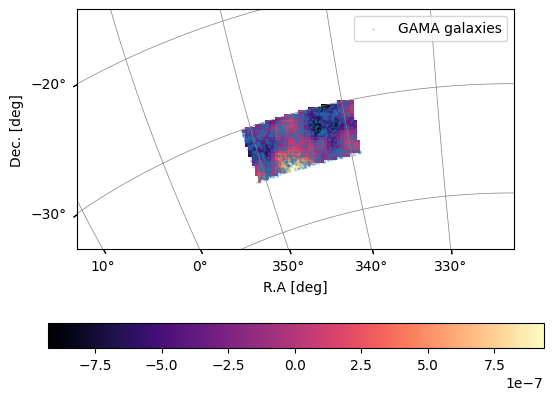

In [16]:
plot_map(MKmap_gama,wproj,W=W_HI_gama)
ax = plt.gca()
plt.scatter(ra_g,dec_g,transform=ax.get_transform('world'),
            s=1,label='GAMA galaxies',color='tab:blue',
            alpha=0.2
           )
plt.legend()

gridding:

First, let us retrieve the box dimensions:

Here I deviated a bit from `meerpower`, because I have some code previously to calculate the dimensions etc. They are well tested (see `tests/test_grid.py`) so I decide that is easier. Essentially it does the same thing, just finding the box length and the origin of the box:

In [17]:
map_mask = W_HI_gama[:,:,0]>0
(x_start,y_start,z_start, xlen, ylen, zlen, rot_back, pos_arr
) = minimum_enclosing_box_of_lightcone(
    ra[map_mask],dec[map_mask],nu,cosmo=cosmo,
    return_coord=True,
    buffkick=5,
)
rot_mat = np.linalg.inv(rot_back)


# this ensures that galaxy position has the same origin as the sky map
(_,_,_,_,_,_,_,gal_pos_arr)=minimum_enclosing_box_of_lightcone(
    ra_g,dec_g,redshift_to_freq(z_g),cosmo=cosmo,
    return_coord=True,
    tile=False,
    rot_mat=rot_mat,
)

In [18]:
box_len = np.array([xlen, ylen, zlen,])
box_origin = np.array([x_start,y_start,z_start])


In [19]:
cell2vox_factor = 1.5 # increase for lower resolution FFT Cartesian grid


It is worth noting that, the (X,Y) direction of the minimum enclosing box for the lightcone does not neccessarily align with the direction of the (RA,Dec). Therefore, instead of a target number of pixels it is better to define a target resolution:

In [20]:
comov_dist = cosmo.comoving_distance(z_ch).value

In [21]:
pix_resol_in_deg = np.sqrt(proj_plane_pixel_area(wproj))
pix_resol_in_mpc = np.pi/180*pix_resol_in_deg*cosmo.comoving_distance(z_ch.mean()).value
los_resol_in_mpc = (comov_dist.max()-comov_dist.min())/len(nu)
box_resol = np.array([pix_resol_in_mpc,pix_resol_in_mpc,los_resol_in_mpc])*cell2vox_factor
ndim_rg = box_len/box_resol
ndim_rg = ndim_rg.astype('int')
if ndim_rg[-1] % 2 != 0 : ndim_rg[-1] += 1
box_resol = box_len/ndim_rg

the pixel positions relative to the box origin is

In [22]:
pix_pos_in_box = (
    pos_arr - box_origin[None,:] - box_resol[None,:]/2
)

gal_pos_in_box = (
    gal_pos_arr - box_origin[None,:] - box_resol[None,:]/2
)

After retrieving the box dimensions and the particle positions, you can then retrieve a mesh grid with your choice of assignment and correction scheme. This is done using `pmesh` following `gridimp`

In [23]:
hi_map_rg,hi_weights_rg,pixel_counts_hi_rg = project_particle_to_regular_grid(
    pix_pos_in_box,
    box_len,
    ndim_rg,
    particle_value=MKmap_clean[map_mask].ravel(),
    particle_weights=w_HI[map_mask].ravel(),
)

gal_map_rg,gal_weights_rg,pixel_counts_gal_rg = project_particle_to_regular_grid(
    gal_pos_in_box,
    box_len,
    ndim_rg,
)

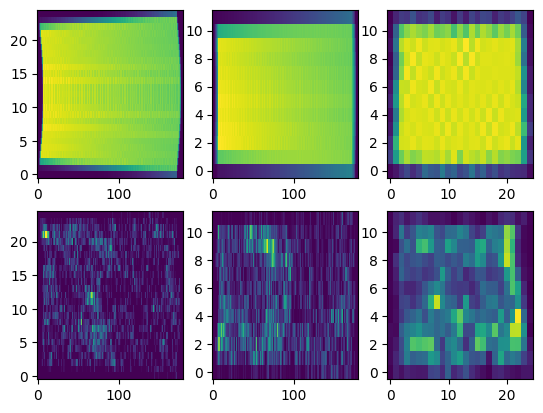

In [24]:
### Gridding sanity-check
fig, axes = plt.subplots(2,3)
for i in range(3):
    axes[0,i].imshow(
        pixel_counts_hi_rg.value.mean(axis=i),interpolation='none',
        aspect='auto',
        origin='lower',
    )
    axes[1,i].imshow(
        pixel_counts_gal_rg.value.mean(axis=i),interpolation='none',
        aspect='auto',
        origin='lower',
    )

In [25]:
(nx_rg,ny_rg,nz_rg) = ndim_rg

In [26]:
blackman = np.reshape(np.tile(
    np.blackman(nz_rg), (nx_rg,ny_rg)), ndim_rg
) # Blackman function along every LoS

tukey_alpha = 0.8
tukey = np.reshape( np.tile(signal.windows.tukey(nz_rg, alpha=tukey_alpha), (nx_rg,ny_rg)) , (nx_rg,ny_rg,nz_rg) ) # Blackman function along every LoS

#taper_HI = blackman
#taper_g = blackman
taper_HI = tukey
#taper_g = tukey
#taper_HI = 1
taper_g = 1

Text(0.5, 1.0, 'Slice through x-axis')

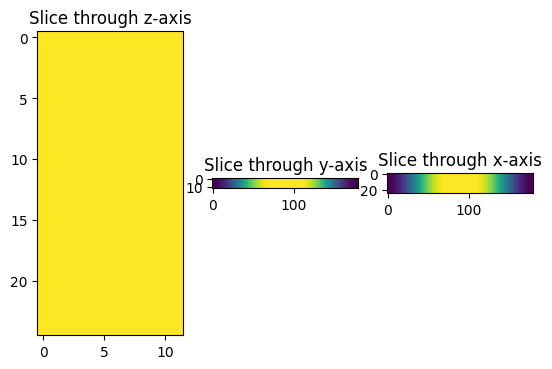

In [27]:
fig, axs = plt.subplots(1,3)
axs[0].imshow(taper_HI[:,:,int(nz_rg/2)].T,
              interpolation='none',vmin=0,vmax=1)
axs[0].set_title('Slice through z-axis')
axs[1].imshow(taper_HI[:,int(ny_rg/2),:],interpolation='none')
axs[1].set_title('Slice through y-axis')
axs[2].imshow(taper_HI[int(nx_rg/2),:,:],interpolation='none')
axs[2].set_title('Slice through x-axis')